Purpose of this notebook is to help generate history from the sample_data created from curate_history_data.ipynb

In [1]:
import os
import sys
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import random
import seaborn as sns
import hashlib
import time

In [2]:
# Add the project root directory to the Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

In [3]:
!ls $project_root/src

__pycache__           feature_extractor.py
constants.py          history_search_app.py


In [4]:
from src.constants import EMBEDDING_MODELS_DICT
from src.feature_extractor import FeatureExtractor

In [5]:
with open("../data/sample_data_by_lang.pkl", "rb") as f:
    sample_data_by_lang = pickle.load(f)

with open("../data/sample_embeddings_by_lang.pkl", "rb") as f:
    sample_embeddings_by_lang = pickle.load(f)

In [6]:
sample_data_by_lang.keys()

dict_keys(['en', 'fr', 'es', 'de', 'ru'])

In [7]:
sample_data_by_lang['en']

,url,title,description,topic,lang,domain,combined_text
0,http://wordstormcasserole.com/boombycindyjoseph/,Review: BOOM! By Cindy Joseph Makeup,Review: BOOM! By Cindy Joseph Makeup November ...,,en,wordstormcasserole.com,Review: BOOM! By Cindy Joseph Makeup Review: B...
1,http://rhodesokla.com/2013/09/major-oklahoma-t...,Major Oklahoma Tort Reform Laws Restored,Major Oklahoma Tort Reform Laws Restored Septe...,,en,rhodesokla.com,Major Oklahoma Tort Reform Laws Restored Major...
2,https://www.theweathernetwork.com/ca/weather/o...,"Vaughan, ON","Vaughan, ON Would you like to add this locatio...",,en,www.theweathernetwork.com,"Vaughan, ON Vaughan, ON Would you like to add ..."
3,http://www.city-data.com/city/Vernon-Texas.html,"Vernon, Texas",Follow city-data.com founder on our Forum or@L...,,en,www.city-data.com,"Vernon, Texas Follow city-data.com founder on ..."
4,http://forums.moneysavingexpert.com/showthread...,Welcometo theMSE Forums,Welcometo the MSE Forums We're home to a fanta...,,en,forums.moneysavingexpert.com,Welcometo theMSE Forums Welcometo the MSE Foru...
...,...,...,...,...,...,...,...
34995,http://www.babynamespedia.com/meaning/Robin/m,Robin - Meaning of Robin,What does Robin mean? Pronounce Robin [ 2 syll...,,en,www.babynamespedia.com,Robin - Meaning of Robin What does Robin mean?...
34996,https://www.leaf.tv/articles/how-to-make-a-gri...,How to Make a Grilled Cheese Sandwich in a Mic...,"When it comes to comfort food, the grilled che...",,en,www.leaf.tv,How to Make a Grilled Cheese Sandwich in a Mic...
34997,http://www.howtocreate.co.uk/tutorials/javascr...,JavaScript tutorial - Variables,Variables Variable types are not important in ...,,en,www.howtocreate.co.uk,JavaScript tutorial - Variables Variables Vari...
34998,https://www.petcarerx.com/article/5-treatments...,5 Treatments For Cat Dry Skin,5 Treatments For Cat Dry Skin Getting Rid of Y...,,en,www.petcarerx.com,5 Treatments For Cat Dry Skin 5 Treatments For...


In [8]:
categories = [ "Arts & Entertainment",
              "Business and Consumer Services",
              "Community and Society",
              "Computers Electronics and Technology",
              "Ecommerce & Shopping",
              "Finance",
              "Food and Drink",
              "Gambling",
              "Games",
              "Health",
              "Heavy Industry and Engineering",
              "Hobbies and Leisure",
              "Home and Garden",
              "Jobs and Career",
              "Law and Government",
              "Lifestyle",
              "News & Media Publishers",
              "Pets and Animals",
              "Reference Materials",
              "Science and Education",
              "Sports",
              "Travel and Tourism",
              "Vehicles",
              "Adult"
             ]
print(len(categories))

24


In [9]:
from gliner import GLiNER

gliner_model = GLiNER.from_pretrained("urchade/gliner_largev2")

texts = sample_data_by_lang['fr']['combined_text'].values.tolist()[:2]

labels = categories[::]

for text in texts:
    entities = gliner_model.predict_entities(text, labels)
    # for entity in entities:
    themes = list({entity["label"] for entity in entities})
    print(text, "->", themes)
    print()


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

/Users/cgopal/work/smart_search/venv/lib/python3.12/site-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


69 bateaux chinois interdits de pêche dans les eaux congolaises Soixante-neuf bateaux appartenant à trois entreprises chinoises accusées de pratiques illicites ont été interdits de pêche dans les eaux congolaises. -> ['Vehicles', 'Hobbies and Leisure']

Une adolescente meurt à Chartres après avoir mangé un kebab Son intoxication alimentaire serait liée à un kebab pris dans un restaurant de la ville. Celui-ci a été fermé pour raisons sanitaires. -> ['Food and Drink', 'Health']



In [10]:
# batch_res = gliner_model.batch_predict_entities(texts, labels)

In [11]:
def detect_themes(gliner_model, df, labels):
    texts = df['combined_text'].values.tolist()
    themes_result = []
    for text in tqdm(texts):
        entities = gliner_model.predict_entities(text, labels)
        themes = list({entity["label"] for entity in entities})
        themes_result.append(themes)
        # print(text, "->", themes)
        # print()
    return themes_result
    

In [12]:
sample_data_by_lang_updated = {}
for lang, sample_data in sample_data_by_lang.items():
    print(lang)
    themes_result = detect_themes(gliner_model, sample_data, labels)
    sample_data['themes'] = themes_result
    sample_data_by_lang_updated[lang] = sample_data

en



00%|████████████████████████████████████████████████████████████████████████████████████| 35000/35000 [3:50:38<00:00,  2.53it/s]

fr



00%|████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [27:17<00:00,  3.05it/s]

es



00%|████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [25:38<00:00,  3.25it/s]

de



00%|████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [32:29<00:00,  2.56it/s]

ru



00%|████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [32:00<00:00,  2.60it/s]

In [14]:
### Use the below cell to recreate else if you want to recreate then uncomment this.
# with open("../data/sample_data_by_lang_updated.pkl", "wb") as f:
#     pickle.dump(sample_data_by_lang_updated, f)

In [9]:
with open("../data/sample_data_by_lang_updated.pkl", "rb") as f:
    sample_data_by_lang_updated = pickle.load(f)

In [10]:
sample_data_by_lang_updated['en']

,url,title,description,topic,lang,domain,combined_text,themes
0,http://wordstormcasserole.com/boombycindyjoseph/,Review: BOOM! By Cindy Joseph Makeup,Review: BOOM! By Cindy Joseph Makeup November ...,,en,wordstormcasserole.com,Review: BOOM! By Cindy Joseph Makeup Review: B...,"[Community and Society, Lifestyle, Arts & Ente..."
1,http://rhodesokla.com/2013/09/major-oklahoma-t...,Major Oklahoma Tort Reform Laws Restored,Major Oklahoma Tort Reform Laws Restored Septe...,,en,rhodesokla.com,Major Oklahoma Tort Reform Laws Restored Major...,[Law and Government]
2,https://www.theweathernetwork.com/ca/weather/o...,"Vaughan, ON","Vaughan, ON Would you like to add this locatio...",,en,www.theweathernetwork.com,"Vaughan, ON Vaughan, ON Would you like to add ...",[]
3,http://www.city-data.com/city/Vernon-Texas.html,"Vernon, Texas",Follow city-data.com founder on our Forum or@L...,,en,www.city-data.com,"Vernon, Texas Follow city-data.com founder on ...","[Community and Society, Health]"
4,http://forums.moneysavingexpert.com/showthread...,Welcometo theMSE Forums,Welcometo the MSE Forums We're home to a fanta...,,en,forums.moneysavingexpert.com,Welcometo theMSE Forums Welcometo the MSE Foru...,"[Community and Society, Finance, Law and Gover..."
...,...,...,...,...,...,...,...,...
34995,http://www.babynamespedia.com/meaning/Robin/m,Robin - Meaning of Robin,What does Robin mean? Pronounce Robin [ 2 syll...,,en,www.babynamespedia.com,Robin - Meaning of Robin What does Robin mean?...,[]
34996,https://www.leaf.tv/articles/how-to-make-a-gri...,How to Make a Grilled Cheese Sandwich in a Mic...,"When it comes to comfort food, the grilled che...",,en,www.leaf.tv,How to Make a Grilled Cheese Sandwich in a Mic...,[Food and Drink]
34997,http://www.howtocreate.co.uk/tutorials/javascr...,JavaScript tutorial - Variables,Variables Variable types are not important in ...,,en,www.howtocreate.co.uk,JavaScript tutorial - Variables Variables Vari...,[Computers Electronics and Technology]
34998,https://www.petcarerx.com/article/5-treatments...,5 Treatments For Cat Dry Skin,5 Treatments For Cat Dry Skin Getting Rid of Y...,,en,www.petcarerx.com,5 Treatments For Cat Dry Skin 5 Treatments For...,"[Health, Pets and Animals]"


In [11]:
from collections import Counter
import matplotlib.pyplot as plt

def count_themes(df):
    themes_ctr = Counter()
    for themes in df['themes'].apply(list).values.tolist():
        if themes != []:
            themes_ctr.update(themes)
    return themes_ctr

def plot_theme_counts(themes_ctr, lang):
    categories = list(themes_ctr.keys())
    counts = list(themes_ctr.values())
    
    # Create the bar chart
    plt.figure(figsize=(10, 8))
    plt.barh(categories, counts, color='skyblue')
    plt.xlabel('Count')
    plt.ylabel('Themes')
    plt.title(f'Themes Distribution for {lang}')
    plt.tight_layout()  # Adjust layout to prevent label overlap
    plt.show()


Counter({'Health': 6715, 'Reference Materials': 5009, 'Science and Education': 4814, 'Finance': 4450, 'Jobs and Career': 4404, 'Law and Government': 4296, 'Food and Drink': 3335, 'Arts & Entertainment': 2866, 'Community and Society': 2831, 'Computers Electronics and Technology': 2410, 'Travel and Tourism': 1977, 'Lifestyle': 1620, 'Business and Consumer Services': 1449, 'Sports': 1406, 'Vehicles': 1277, 'News & Media Publishers': 1268, 'Home and Garden': 1264, 'Pets and Animals': 1252, 'Hobbies and Leisure': 1033, 'Ecommerce & Shopping': 831, 'Heavy Industry and Engineering': 539, 'Games': 311, 'Gambling': 152, 'Adult': 57})


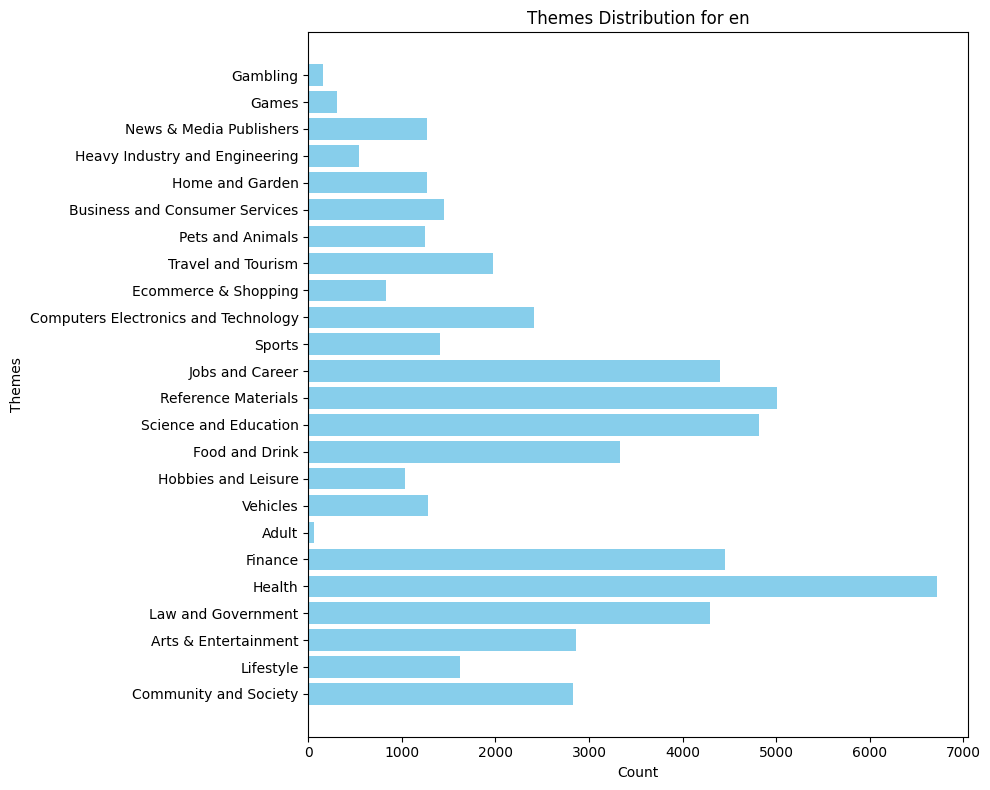

In [12]:
themes_ctr = count_themes(sample_data_by_lang_updated['en'])
print(themes_ctr)
plot_theme_counts(themes_ctr, 'en')

Counter({'Law and Government': 1946, 'Community and Society': 1019, 'Jobs and Career': 988, 'Finance': 830, 'Arts & Entertainment': 710, 'Sports': 477, 'Science and Education': 451, 'Health': 396, 'News & Media Publishers': 324, 'Heavy Industry and Engineering': 224, 'Travel and Tourism': 209, 'Vehicles': 194, 'Lifestyle': 182, 'Business and Consumer Services': 173, 'Computers Electronics and Technology': 159, 'Food and Drink': 126, 'Hobbies and Leisure': 100, 'Pets and Animals': 79, 'Reference Materials': 66, 'Home and Garden': 60, 'Ecommerce & Shopping': 58, 'Gambling': 39, 'Games': 30, 'Adult': 6})


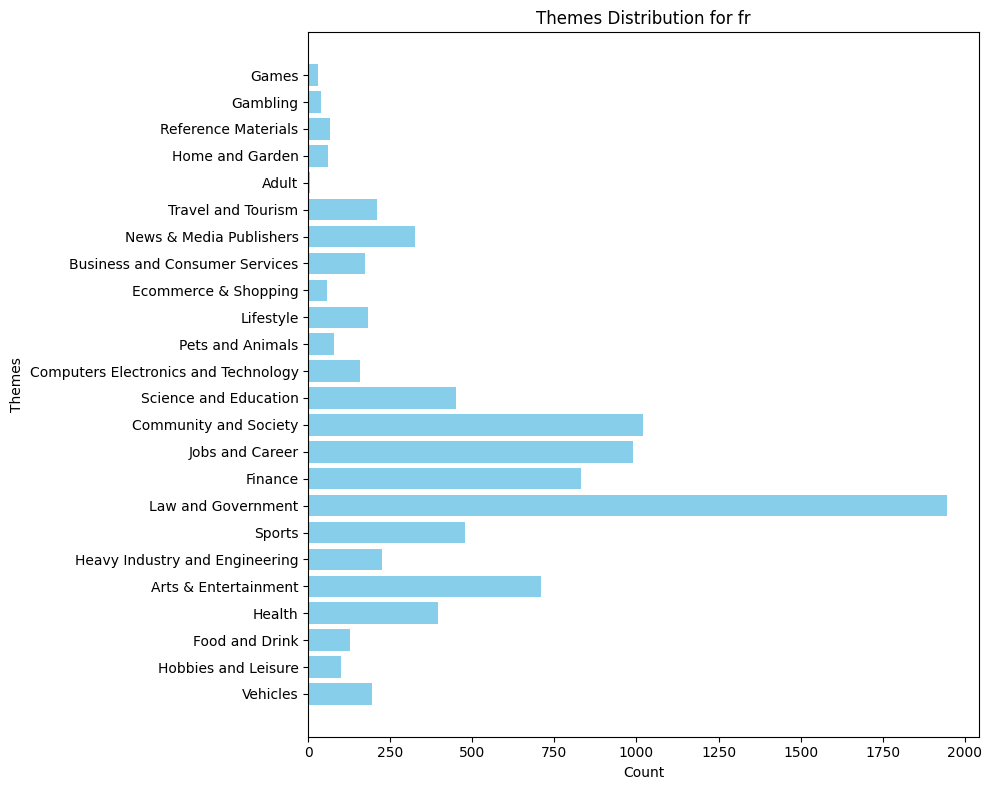

In [13]:
themes_ctr = count_themes(sample_data_by_lang_updated['fr'])
print(themes_ctr)
plot_theme_counts(themes_ctr, 'fr')

Counter({'Law and Government': 1849, 'Sports': 1300, 'Finance': 1030, 'Jobs and Career': 1016, 'Community and Society': 736, 'Health': 530, 'Travel and Tourism': 401, 'Vehicles': 366, 'Science and Education': 299, 'Arts & Entertainment': 255, 'Business and Consumer Services': 220, 'Computers Electronics and Technology': 206, 'Lifestyle': 203, 'News & Media Publishers': 202, 'Heavy Industry and Engineering': 172, 'Food and Drink': 163, 'Hobbies and Leisure': 162, 'Home and Garden': 99, 'Pets and Animals': 95, 'Ecommerce & Shopping': 73, 'Gambling': 67, 'Reference Materials': 55, 'Games': 26, 'Adult': 1})


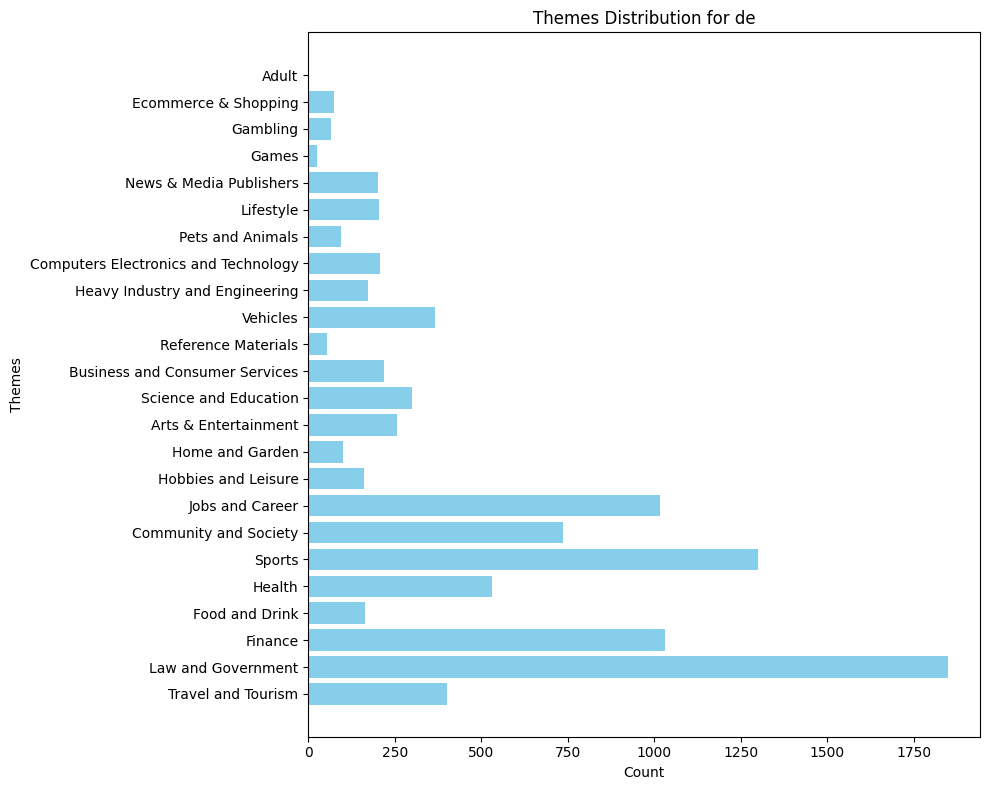

In [14]:
themes_ctr = count_themes(sample_data_by_lang_updated['de'])
print(themes_ctr)
plot_theme_counts(themes_ctr, 'de')

Counter({'Law and Government': 1938, 'Community and Society': 981, 'Arts & Entertainment': 891, 'Jobs and Career': 858, 'Finance': 840, 'Sports': 544, 'Health': 531, 'Travel and Tourism': 389, 'Science and Education': 384, 'Lifestyle': 246, 'Food and Drink': 208, 'News & Media Publishers': 173, 'Vehicles': 171, 'Business and Consumer Services': 157, 'Heavy Industry and Engineering': 134, 'Hobbies and Leisure': 129, 'Home and Garden': 113, 'Pets and Animals': 112, 'Computers Electronics and Technology': 98, 'Reference Materials': 76, 'Ecommerce & Shopping': 54, 'Gambling': 43, 'Games': 24, 'Adult': 4})


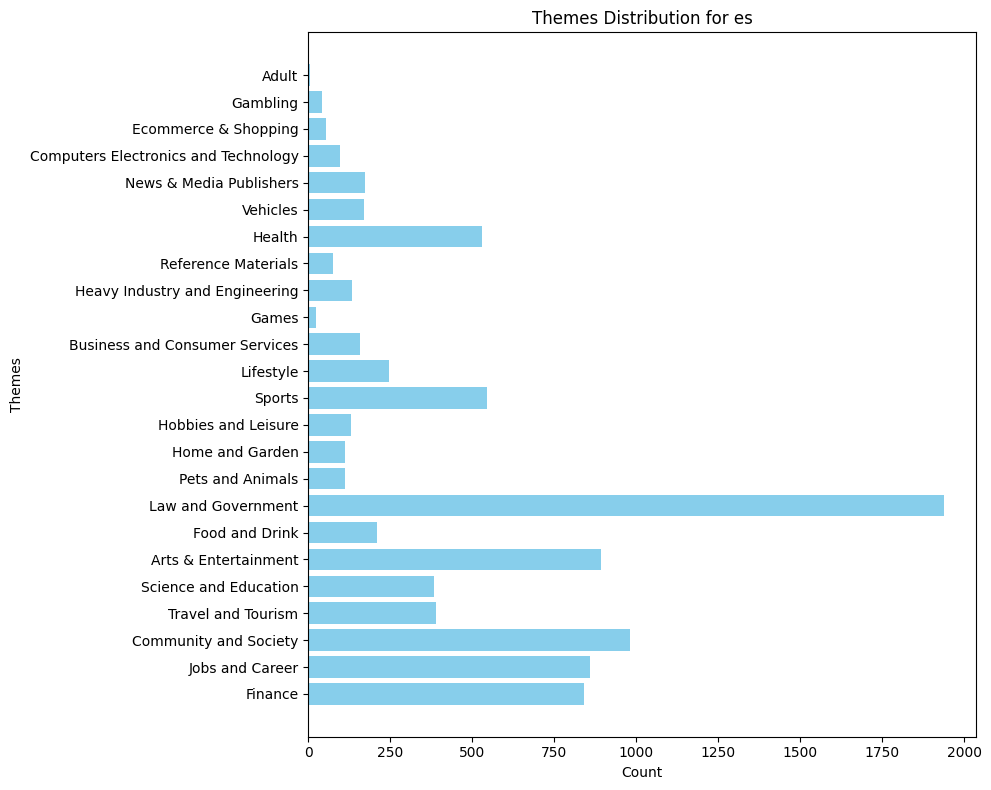

In [15]:
themes_ctr = count_themes(sample_data_by_lang_updated['es'])
print(themes_ctr)
plot_theme_counts(themes_ctr, 'es')

Counter({'Law and Government': 1605, 'Jobs and Career': 812, 'Health': 761, 'Community and Society': 693, 'Sports': 671, 'Science and Education': 600, 'Finance': 578, 'Arts & Entertainment': 551, 'Travel and Tourism': 337, 'News & Media Publishers': 327, 'Pets and Animals': 270, 'Vehicles': 255, 'Lifestyle': 253, 'Hobbies and Leisure': 242, 'Home and Garden': 222, 'Food and Drink': 153, 'Heavy Industry and Engineering': 141, 'Computers Electronics and Technology': 109, 'Business and Consumer Services': 76, 'Reference Materials': 65, 'Gambling': 44, 'Ecommerce & Shopping': 39, 'Games': 30, 'Adult': 19})


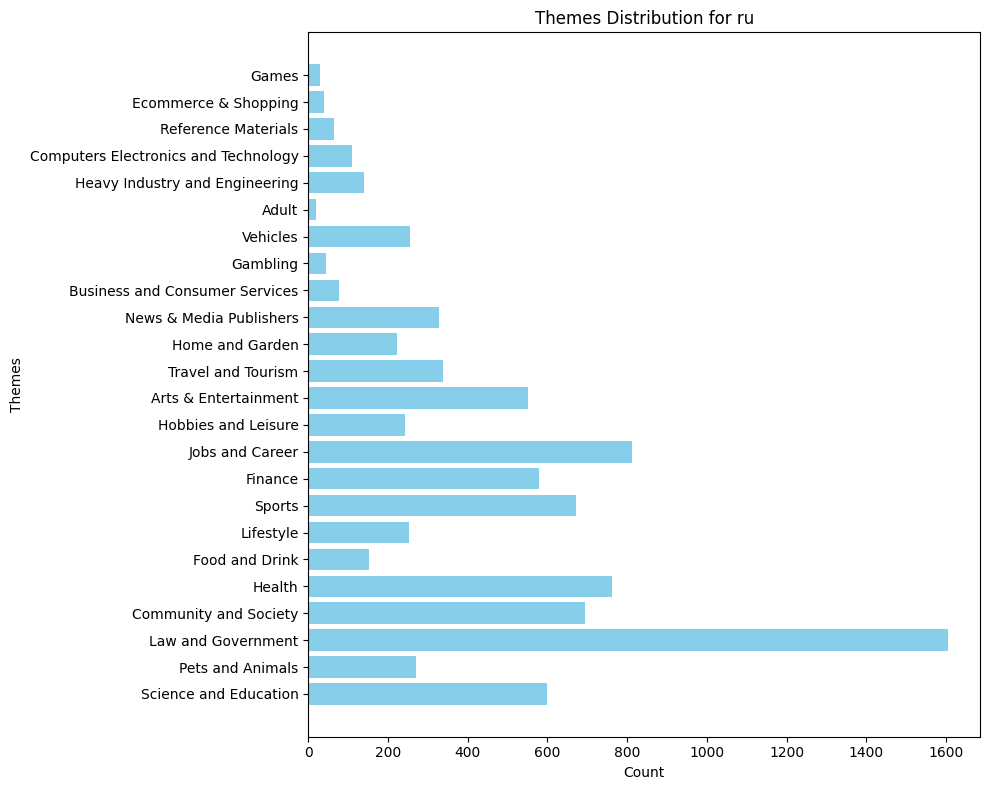

In [16]:
themes_ctr = count_themes(sample_data_by_lang_updated['ru'])
print(themes_ctr)
plot_theme_counts(themes_ctr, 'ru')

#### User profiles

In [17]:
user_profiles = {
    "Health-Conscious Foodie": {
        "categories": ["Health", "Food and Drink", "Lifestyle", "Home and Garden"],
        "description": "Focused on maintaining a healthy lifestyle, exploring recipes, and improving their living environment. Browses for fitness tips, nutritious recipes, and home improvement ideas.",
        "lang": [
            ["en"],  # Strong representation in English (6715 Health, 3335 Food and Drink)
            # ["en", "fr"],  # French has a moderate focus on Health (396) and Food and Drink (126)
        ]
    },
    "Tech Enthusiast": {
        "categories": ["Computers Electronics and Technology", "Games", "Hobbies and Leisure", "Science and Education"],
        "description": "Passionate about technology and gaming. Explores the latest gadgets, software trends, and tech-related hobbies or educational resources.",
        "lang": [
            ["en"],  # English (2410 Computers, 1033 Hobbies, 4814 Science)
            # ["de"],  # German shows interest in tech (206 Computers, 162 Hobbies)
        ]
    },
    "Family-Oriented Homemaker": {
        "categories": ["Home and Garden", "Pets and Animals", "Food and Drink", "Community and Society"],
        "description": "Focused on creating a comfortable home environment, taking care of pets, and engaging with their local community.",
        "lang": [
            ["en"],  # English (1264 Home and Garden, 1252 Pets)
            # ["ru"],  # Russian has strong representation (222 Home, 270 Pets)
        ]
    },
    "Business Professional": {
        "categories": ["Business and Consumer Services", "Finance", "Law and Government", "Jobs and Career"],
        "description": "Interested in career growth, business trends, and financial management. Explores legal or governmental resources for professional purposes.",
        "lang": [
            ["en"],  # English (4450 Finance, 4404 Jobs)
            # ["es"],  # Spanish (840 Finance, 858 Jobs)
            # ["fr"],  # French has high scores in Finance (830) and Law (1946)
        ]
    },
    "Wanderlust Traveler": {
        "categories": ["Travel and Tourism", "Vehicles", "Lifestyle", "Community and Society"],
        "description": "Loves to explore new destinations, research vehicles, and connect with diverse communities during their travels.",
        "lang": [
            ["en"],  # English (1977 Travel, 1277 Vehicles)
            # ["es", "fr"],  # Spanish (389 Travel) and French (209 Travel) align well
        ]
    },
    "Entertainment Junkie": {
        "categories": ["Arts & Entertainment", "Games", "News & Media Publishers", "Sports"],
        "description": "Spends time consuming entertainment-related content such as movies, games, news, and sports events.",
        "lang": [
            ["en"],  # English (2866 Arts, 1406 Sports)
            # ["es"],  # Spanish has high scores in Arts (891) and Sports (544)
        ]
    },
    "Academic Explorer": {
        "categories": ["Science and Education", "Reference Materials", "News & Media Publishers", "Heavy Industry and Engineering"],
        "description": "Interested in learning, researching, and staying informed on academic and industry developments.",
        "lang": [
            ["en"],  # English (4814 Science, 5009 Reference)
            # ["ru"],  # Russian has significant interest in Science (600) and News (327)
            # ["en", "de"],  # English and German both show interest in academic topics
        ]
    },
    "Fashion & Lifestyle Enthusiast": {
        "categories": ["Lifestyle", "Ecommerce & Shopping", "Arts & Entertainment", "Community and Society"],
        "description": "Keeps up with fashion trends, shops online, and engages in arts or cultural activities.",
        "lang": [
            ["en"],  # English (1620 Lifestyle, 831 Ecommerce)
            # ["fr"],  # French shows interest in Lifestyle (182)
        ]
    },
    "Risk-Taker": {
        "categories": ["Gambling", "Finance", "Games", "Sports"],
        "description": "Interested in high-stakes activities like gambling and sports betting, alongside financial planning.",
        "lang": [
            ["en"],  # English (152 Gambling, 4450 Finance)
            # ["de"],  # German has interest in Gambling (67) and Finance (1030)
        ]
    },
    "Pet Lover": {
        "categories": ["Pets and Animals", "Home and Garden", "Community and Society", "Hobbies and Leisure"],
        "description": "Dedicated to pets, frequently browsing for pet care tips, community forums, and leisure activities involving animals.",
        "lang": [
            ["en"],  # English (1252 Pets)
            # ["ru"],  # Russian (270 Pets)
        ]
    },
    "High-Stakes Investor": {
        "categories": ["Finance", "Ecommerce & Shopping", "Heavy Industry and Engineering", "Business and Consumer Services"],
        "description": "Focused on investment opportunities, business growth, and exploring trends in engineering and ecommerce.",
        "lang": [
            ["en"],  # English (4450 Finance, 831 Ecommerce)
            # ["es"],  # Spanish (840 Finance)
        ]
    },
    "Social Butterfly": {
        "categories": ["Community and Society", "Arts & Entertainment", "Travel and Tourism", "News & Media Publishers"],
        "description": "Stays connected to their community, engages with arts and entertainment, and frequently plans trips.",
        "lang": [
            ["en"],  # English (2831 Community, 2866 Arts)
            # ["fr", "es"],  # French and Spanish have strong community representation
        ]
    },
    "Eco-Friendly Enthusiast": {
        "categories": ["Science and Education", "Lifestyle", "Community and Society", "Travel and Tourism"],
        "description": "A user passionate about sustainability, environmental science, and eco-friendly lifestyle choices. Often browses for green travel options and sustainable living tips.",
        "lang": [
            ["en"],  # English (4814 Science, 2831 Community, 1977 Travel)
            # ["es", "fr"],  # Spanish and French also reflect interest in sustainability and travel
        ]
    },
    "Avid Sports Fan": {
        "categories": ["Sports", "News & Media Publishers", "Community and Society", "Vehicles"],
        "description": "An active sports enthusiast who follows games, teams, and live updates. Interested in sports-related vehicles like bikes and cars.",
        "lang": [
            ["en"],  # English (1406 Sports, 1268 News)
            # ["de"],  # German (1300 Sports, 202 News)
        ]
    },
    "News Junkie": {
        "categories": ["News & Media Publishers", "Law and Government", "Community and Society", "Finance"],
        "description": "Someone who loves staying updated with current events, legal updates, and societal trends. Often looks into financial news as well.",
        "lang": [
            ["en"],  # English (1268 News, 4296 Law, 4450 Finance)
            # ["fr"],  # French (324 News, 1946 Law)
            # ["ru"],  # Russian (327 News, 1605 Law)
        ]
    },
    "Creative Hobbyist": {
        "categories": ["Hobbies and Leisure", "Arts & Entertainment", "Lifestyle", "Home and Garden"],
        "description": "A user interested in creative pursuits like crafting, painting, or gardening. Enjoys exploring artistic hobbies and lifestyle trends.",
        "lang": [
            ["en"],  # English (1033 Hobbies, 2866 Arts)
            # ["es"],  # Spanish (129 Hobbies, 891 Arts)
            # ["fr", "de"],  # French and German represent Arts and Hobbies moderately
        ]
    },
    "Gaming Enthusiast": {
        "categories": ["Games", "Computers Electronics and Technology", "Hobbies and Leisure", "Arts & Entertainment"],
        "description": "A user passionate about video games, gaming technology, and related leisure activities. Frequently browses for gaming tips and gadgets.",
        "lang": [
            ["en"],  # English (311 Games, 2410 Computers)
            # ["de"],  # German (26 Games, 206 Computers)
        ]
    },
    "Cultural Explorer": {
        "categories": ["Arts & Entertainment", "Travel and Tourism", "Community and Society", "Food and Drink"],
        "description": "Loves exploring different cultures through art, travel, and cuisine. Frequently browses for cultural festivals, local food, and artistic trends.",
        "lang": [
            ["en"],  # English (2866 Arts, 1977 Travel, 3335 Food)
            # ["fr", "es"],  # French and Spanish have strong cultural representation
        ]
    },
    "Pet-Centric Caregiver": {
        "categories": ["Pets and Animals", "Hobbies and Leisure", "Community and Society", "Health"],
        "description": "Dedicated to pet care and animal welfare. Frequently browses for pet health tips, leisure activities, and animal-friendly communities.",
        "lang": [
            ["en"],  # English (1252 Pets, 6715 Health)
            # ["ru"],  # Russian (270 Pets, 761 Health)
        ]
    },
    "High-Tech Investor": {
        "categories": ["Finance", "Computers Electronics and Technology", "Business and Consumer Services", "Ecommerce & Shopping"],
        "description": "Interested in tech-driven investments, emerging markets, and ecommerce trends. Looks for opportunities in the intersection of finance and technology.",
        "lang": [
            ["en"],  # English (4450 Finance, 2410 Computers)
            # ["es", "fr"],  # Spanish and French also show interest in Finance
        ]
    },
    "Adventurous Gambler": {
        "categories": ["Gambling", "Games", "Finance", "Lifestyle"],
        "description": "A user seeking thrills through high-risk gambling and gaming activities, often coupled with a flair for an adventurous lifestyle.",
        "lang": [
            ["en"],  # English (152 Gambling, 311 Games)
            # ["de"],  # German (67 Gambling, 26 Games)
        ]
    },
    "Digital Nomad": {
        "categories": ["Travel and Tourism", "Computers Electronics and Technology", "Lifestyle", "Finance"],
        "description": "A tech-savvy traveler who combines remote work with travel. Looks for gadgets, lifestyle tips, and financial resources to support their nomadic lifestyle.",
        "lang": [
            ["en"],  # English (1977 Travel, 2410 Computers)
            # ["es", "fr"],  # Spanish and French also have representation in Travel and Lifestyle
        ]
    },
    "Tech Developer": {
        "categories": ["Computers Electronics and Technology", "Hobbies and Leisure", "Science and Education"],
        "description": "A user passionate about coding, software development, and exploring cutting-edge technologies. Often browses tutorials, developer tools, and technical resources.",
        "lang": [
            ["en"],  # Strong representation in English (2410 Computers, 4814 Science)
            # ["de"],  # German also reflects tech interests (206 Computers)
            # ["en", "fr"],  # Bilingual developers in English and French regions
        ]
    },
    "Software Engineer": {
        "categories": ["Computers Electronics and Technology", "Jobs and Career", "Business and Consumer Services"],
        "description": "A professional working on software design and implementation, browsing for technical documentation, career opportunities, and business-related trends.",
        "lang": [
            ["en"],  # English dominates Computers (2410) and Jobs (4404)
            # ["de", "fr"],  # German and French have moderate interest in Jobs and Tech
        ]
    },
    "Project Manager": {
        "categories": ["Jobs and Career", "Business and Consumer Services", "Finance", "Community and Society"],
        "description": "A user responsible for planning and executing projects, focusing on management strategies, financial planning, and collaboration tools.",
        "lang": [
            ["en"],  # English (4404 Jobs, 4450 Finance)
            # ["fr"],  # French shows interest in Jobs (988) and Business (173)
        ]
    },
    "Government Clerk": {
        "categories": ["Law and Government", "Community and Society", "Reference Materials", "Jobs and Career"],
        "description": "A professional working in public administration, frequently browsing legal resources, government updates, and career growth opportunities.",
        "lang": [
            ["en"],  # English (4296 Law, 2831 Community)
            # ["fr", "es"],  # French (1946 Law, 1019 Community) and Spanish (1938 Law) also fit
        ]
    },
    "Financial Consultant": {
        "categories": ["Finance", "Business and Consumer Services", "Jobs and Career", "Ecommerce & Shopping"],
        "description": "A professional advising clients on financial planning, investments, and business strategies. Often browses market trends and ecommerce insights.",
        "lang": [
            ["en"],  # English (4450 Finance, 1449 Business)
            # ["es"],  # Spanish shows high interest in Finance (840)
        ]
    },
    "Academia Researcher": {
        "categories": ["Science and Education", "Reference Materials", "News & Media Publishers"],
        "description": "An academic focused on research and publishing. Frequently browses scientific articles, reference materials, and academic news.",
        "lang": [
            ["en"],  # English (4814 Science, 5009 Reference)
            # ["fr", "ru"],  # French and Russian have strong academic interest
        ]
    },
    "Freelance Creative": {
        "categories": ["Arts & Entertainment", "Hobbies and Leisure", "Lifestyle", "Ecommerce & Shopping"],
        "description": "A freelancer working on creative projects like design, writing, or music. Browses for inspiration, lifestyle trends, and ecommerce tools.",
        "lang": [
            ["en"],  # English (2866 Arts, 1033 Hobbies)
            # ["es"],  # Spanish reflects interest in Arts (891)
        ]
    },
    "Automotive Enthusiast": {
        "categories": ["Vehicles", "Travel and Tourism", "Heavy Industry and Engineering", "Sports"],
        "description": "A user fascinated by vehicles and engineering, browsing for car reviews, travel options, and automotive technology.",
        "lang": [
            ["en"],  # English (1277 Vehicles, 1977 Travel)
            # ["de"],  # German shows strong interest in Vehicles (366)
        ]
    },
    "Health Advisor": {
        "categories": ["Health", "Science and Education", "Community and Society"],
        "description": "A professional focused on health and wellness, frequently browsing for medical research, community health programs, and educational resources.",
        "lang": [
            ["en"],  # English dominates Health (6715)
            # ["ru"],  # Russian (761 Health) aligns well with health-related browsing
        ]
    },
    "Marketing Specialist": {
        "categories": ["Business and Consumer Services", "Ecommerce & Shopping", "Arts & Entertainment", "Community and Society"],
        "description": "A professional focusing on marketing strategies, trends, and creative campaigns. Frequently browses for ecommerce tools and consumer insights.",
        "lang": [
            ["en"],  # English (1449 Business, 831 Ecommerce)
            # ["es"],  # Spanish shows interest in Business (157) and Arts (891)
        ]
    },
    "Urban Planner": {
        "categories": ["Law and Government", "Community and Society", "Home and Garden", "Science and Education"],
        "description": "A professional working on urban development and planning. Often browses legal frameworks, societal trends, and design resources.",
        "lang": [
            ["en"],  # English (4296 Law, 2831 Community)
            # ["de", "fr"],  # German and French show interest in Law and Community
        ]
    },
    "Public Relations Manager": {
        "categories": ["News & Media Publishers", "Community and Society", "Jobs and Career"],
        "description": "A professional specializing in managing public image and communication strategies. Focuses on news, societal trends, and career opportunities.",
        "lang": [
            ["en"],  # English (1268 News, 2831 Community)
            # ["fr"],  # French (324 News, 1019 Community)
        ]
    },
    "School Teacher": {
        "categories": ["Science and Education", "Reference Materials", "Community and Society"],
        "description": "An educator focused on teaching, preparing lesson plans, and staying updated on educational trends. Frequently browses for academic resources and community engagement tools.",
        "lang": [
            ["en"],  # English dominates Science (4814) and Reference (5009)
            # ["fr"],  # French (451 Science, 66 Reference) aligns with education
        ]
    },
    "College Student": {
        "categories": ["Science and Education", "Hobbies and Leisure", "News & Media Publishers", "Lifestyle"],
        "description": "A student exploring academic topics, leisure activities, and lifestyle trends. Often browses for study materials and entertainment content.",
        "lang": [
            ["en"],  # English leads in Science (4814) and Hobbies (1033)
            # ["es"],  # Spanish shows interest in Science (384) and Lifestyle (246)
        ]
    },
    "Retired Person": {
        "categories": ["Health", "Home and Garden", "Community and Society", "Travel and Tourism"],
        "description": "A retired individual focused on health, home improvement, and staying socially active. Often browses for travel options and community events.",
        "lang": [
            ["en"],  # English dominates Health (6715) and Travel (1977)
            # ["de"],  # German shows interest in Health (530) and Travel (401)
        ]
    },
    "Social Worker": {
        "categories": ["Community and Society", "Law and Government", "Health", "Science and Education"],
        "description": "A professional committed to societal welfare, browsing resources on health, legal frameworks, and education for community betterment.",
        "lang": [
            ["en"],  # English dominates Community (2831) and Health (6715)
            # ["fr", "es"],  # French (1019 Community) and Spanish (981 Community) align well
        ]
    },
    "Daily Wage Worker": {
        "categories": ["Jobs and Career", "Community and Society", "Law and Government"],
        "description": "A user focused on finding job opportunities, browsing legal resources, and connecting with community programs for daily wage earners.",
        "lang": [
            ["en"],  # English (4404 Jobs, 4296 Law)
            # ["es"],  # Spanish has moderate representation in Jobs (858) and Law (1938)
        ]
    },
    "Contract Worker": {
        "categories": ["Jobs and Career", "Finance", "Business and Consumer Services"],
        "description": "A professional seeking short-term contracts or freelance opportunities. Often browses for financial planning and business trends.",
        "lang": [
            ["en"],  # English leads in Jobs (4404) and Finance (4450)
            # ["fr"],  # French shows interest in Jobs (988) and Finance (830)
        ]
    },
    "Teenager": {
        "categories": ["Games", "Arts & Entertainment", "Hobbies and Leisure", "Lifestyle"],
        "description": "A young user exploring gaming, entertainment, and hobbies. Often browses for social media trends, creative ideas, and lifestyle tips.",
        "lang": [
            ["en"],  # English (311 Games, 2866 Arts)
            # ["es"],  # Spanish reflects Arts (891) and Hobbies (129)
        ]
    },
    "School Student": {
        "categories": ["Science and Education", "Games", "Hobbies and Leisure", "Lifestyle"],
        "description": "A student curious about educational topics and recreational activities. Frequently browses for school projects, gaming tips, and hobbies.",
        "lang": [
            ["en"],  # English dominates Science (4814) and Games (311)
            # ["fr"],  # French shows moderate interest in Science (451)
        ]
    },
}


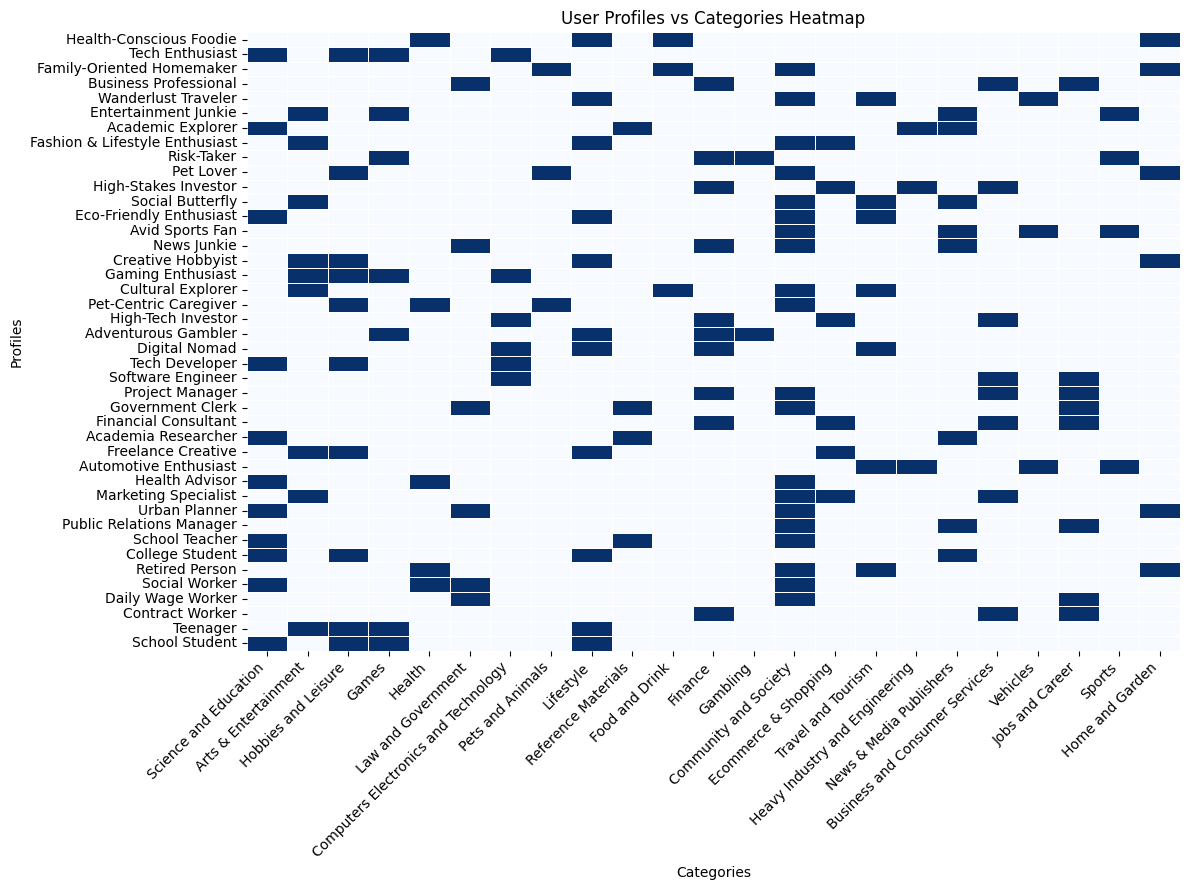

In [18]:
# Get all unique categories
categories = list(set(cat for profile in user_profiles.values() for cat in profile["categories"]))

# Prepare data for heatmap
heatmap_data = []
for profile_name, profile_info in user_profiles.items():
    heatmap_data.append([1 if category in profile_info["categories"] else 0 for category in categories])

heatmap_df = pd.DataFrame(heatmap_data, columns=categories, index=user_profiles.keys())
plt.figure(figsize=(12, 9))
sns.heatmap(heatmap_df, annot=False, cbar=False, cmap="Blues", fmt="d", linewidths=0.5)
plt.title("User Profiles vs Categories Heatmap")
plt.xlabel("Categories")
plt.ylabel("Profiles")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

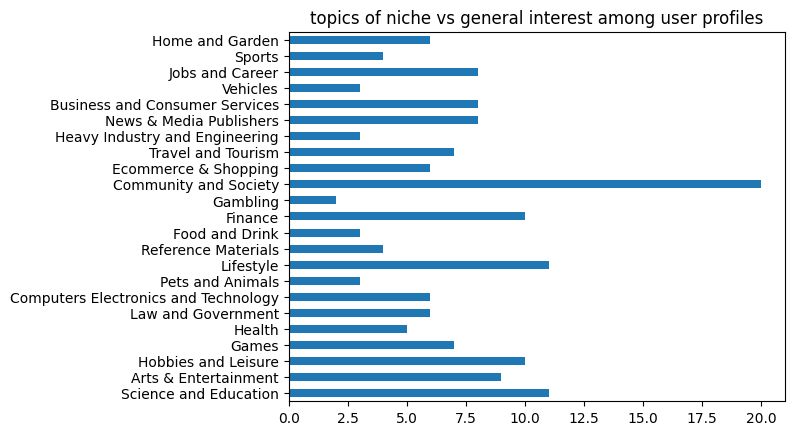

In [19]:
plt.title("topics of niche vs general interest among user profiles")
heatmap_df.sum(axis=0).plot(kind='barh');

In [20]:
len(user_profiles)

42

In [21]:
def apply_category_filter(categories, themes):
    for cat in categories:
        if cat in themes:
            return True
    return False


def generate_url_hash(url):
    hash_object = hashlib.md5(url.encode("utf-8"))  
    url_hash = int(hash_object.hexdigest(), 16) % (10 ** 14) 
    return url_hash


def generate_last_visit_date(index):
    base_time = int(time.time() * 1_000_000)  # Current time in microseconds
    return base_time + index * 2_000  # Increment by 2000 microseconds (2ms) per row


def generate_user_profiles(user_profiles):
    """ generate n user profiles """
    profile_name = random.choice(list(user_profiles.keys()))
    print(profile_name)
    profile = user_profiles[profile_name]
    categories = profile['categories']
    langs = random.choice(profile['lang'])
    desc = profile['description']
    print(categories)
    print(langs)
    num_samples = random.randint(250, 350)
    print(f"num_samples = {num_samples}")
    frecency = [random.randint(10,500) for _ in range(num_samples)]
    res = []
    for lang in langs:
        df = sample_data_by_lang_updated.get(lang)
        res.append(df.loc[df['themes'].apply(list).apply(lambda themes: apply_category_filter(categories, themes))])
    res_df = pd.concat(res, axis=0).sample(num_samples).reset_index(drop=True)
    res_df['frecency'] = frecency
    res_df['url_hash'] = res_df['url'].apply(generate_url_hash)
    res_df["last_visit_date"] = [generate_last_visit_date(i) for i in range(len(res_df))]

    return profile_name, categories, langs, desc, res_df

In [22]:
profiles_generated = []

for i in range(25):
    profile_name, categories, langs, desc, res_df = generate_user_profiles(user_profiles)
    profiles_generated.append(
        {
            'profile_name': profile_name,
            'categories': categories,
            'langs': langs,
            'desc': desc,
            'df': res_df,
        }
    )
    

Cultural Explorer
['Arts & Entertainment', 'Travel and Tourism', 'Community and Society', 'Food and Drink']
['en']
num_samples = 297
High-Stakes Investor
['Finance', 'Ecommerce & Shopping', 'Heavy Industry and Engineering', 'Business and Consumer Services']
['en']
num_samples = 311
Daily Wage Worker
['Jobs and Career', 'Community and Society', 'Law and Government']
['en']
num_samples = 303
Daily Wage Worker
['Jobs and Career', 'Community and Society', 'Law and Government']
['en']
num_samples = 346
Government Clerk
['Law and Government', 'Community and Society', 'Reference Materials', 'Jobs and Career']
['en']
num_samples = 330
Government Clerk
['Law and Government', 'Community and Society', 'Reference Materials', 'Jobs and Career']
['en']
num_samples = 273
Retired Person
['Health', 'Home and Garden', 'Community and Society', 'Travel and Tourism']
['en']
num_samples = 263
Marketing Specialist
['Business and Consumer Services', 'Ecommerce & Shopping', 'Arts & Entertainment', 'Community a

In [23]:
len(profiles_generated)

25

In [24]:
profiles_generated[2]

{'profile_name': 'Daily Wage Worker',
 'categories': ['Jobs and Career',
  'Community and Society',
  'Law and Government'],
 'langs': ['en'],
 'desc': 'A user focused on finding job opportunities, browsing legal resources, and connecting with community programs for daily wage earners.',
 'df':                                                    url  \
 0                               http://www.hhchen.com/   
 1    http://www.mayoclinic.org/healthy-lifestyle/nu...   
 2    http://www.answers.com/Q/How_did_the_cold_war_...   
 3    http://www.thestate.com/news/politics-governme...   
 4    http://buyingcrueltyfree.com/category/brands/b...   
 ..                                                 ...   
 298  http://blog.tenthamendmentcenter.com/2013/08/w...   
 299          https://www.britannica.com/topic/marriage   
 300  https://www.bustle.com/articles/87662-how-to-g...   
 301  http://www.yg-audition.com/next-generation/glo...   
 302                            http://whitehallar.org/ 

In [25]:
with open("../data/profiles_generated.pkl", "wb") as f:
    pickle.dump(profiles_generated, f)

In [26]:
user_profiles.keys()

dict_keys(['Health-Conscious Foodie', 'Tech Enthusiast', 'Family-Oriented Homemaker', 'Business Professional', 'Wanderlust Traveler', 'Entertainment Junkie', 'Academic Explorer', 'Fashion & Lifestyle Enthusiast', 'Risk-Taker', 'Pet Lover', 'High-Stakes Investor', 'Social Butterfly', 'Eco-Friendly Enthusiast', 'Avid Sports Fan', 'News Junkie', 'Creative Hobbyist', 'Gaming Enthusiast', 'Cultural Explorer', 'Pet-Centric Caregiver', 'High-Tech Investor', 'Adventurous Gambler', 'Digital Nomad', 'Tech Developer', 'Software Engineer', 'Project Manager', 'Government Clerk', 'Financial Consultant', 'Academia Researcher', 'Freelance Creative', 'Automotive Enthusiast', 'Health Advisor', 'Marketing Specialist', 'Urban Planner', 'Public Relations Manager', 'School Teacher', 'College Student', 'Retired Person', 'Social Worker', 'Daily Wage Worker', 'Contract Worker', 'Teenager', 'School Student'])

In [27]:
user_profile_queries = {
    "Health-Conscious Foodie": {
        "queries": {
            "en": [
                "healthy smoothie recipes",
                "home yoga workouts",
                "best plants for indoor air quality",
                "nutritional value of kale",
                "how to improve gut health",
            ],
            # "fr": [
            #     "recettes de smoothies sains",
            #     "exercices de yoga à domicile",
            #     "meilleures plantes pour purifier l'air",
            #     "valeur nutritionnelle du chou frisé",
            #     "comment améliorer la santé intestinale",
            # ]
        }
    },
    "Tech Enthusiast": {
        "queries": {
            "en": [
                "latest iPhone specs",
                "top 10 gaming laptops",
                "how to set up a home server",
                "introduction to Python programming",
                "latest trends in artificial intelligence",
            ],
            # "de": [
            #     "neueste iPhone-Spezifikationen",
            #     "beste Gaming-Laptops",
            #     "wie man einen Heimserver einrichtet",
            #     "Einführung in die Python-Programmierung",
            #     "Trends in künstlicher Intelligenz",
            # ]
        }
    },
    "Family-Oriented Homemaker": {
        "queries": {
            "en": [
                "best dog breeds for families",
                "how to decorate a small kitchen",
                "easy dinner recipes for kids",
                "local community events near me",
                "pet-friendly vacation spots",
            ],
            # "ru": [
            #     "лучшие породы собак для семьи",
            #     "как украсить маленькую кухню",
            #     "простые рецепты ужина для детей",
            #     "местные мероприятия в моем районе",
            #     "места отдыха, где разрешены животные",
            # ]
        }
    },
    "Business Professional": {
        "queries": {
            "en": [
                "how to negotiate a raise",
                "top finance news websites",
                "business loan options in 2024",
                "latest leadership strategies",
                "investment trends for small businesses",
            ],
            # "es": [
            #     "cómo negociar un aumento",
            #     "mejores sitios web de noticias financieras",
            #     "opciones de préstamos para negocios en 2024",
            #     "estrategias de liderazgo actuales",
            #     "tendencias de inversión para pequeñas empresas",
            # ],
            # "fr": [
            #     "comment négocier une augmentation",
            #     "meilleurs sites d'actualités financières",
            #     "options de prêts commerciaux en 2024",
            #     "stratégies de leadership modernes",
            #     "tendances d'investissement pour les petites entreprises",
            # ]
        }
    },
    "Wanderlust Traveler": {
        "queries": {
            "en": [
                "cheapest flights to Paris",
                "top 10 beaches in the Caribbean",
                "packing checklist for Europe",
                "best road trip routes in Canada",
                "cultural festivals in Asia",
            ],
            # "fr": [
            #     "vols pas chers pour Paris",
            #     "meilleures plages des Caraïbes",
            #     "liste de choses à emporter pour l'Europe",
            #     "meilleurs itinéraires de road trip au Canada",
            #     "festivals culturels en Asie",
            # ],
            # "es": [
            #     "vuelos baratos a París",
            #     "mejores playas del Caribe",
            #     "lista de empaque para Europa",
            #     "mejores rutas de viaje por carretera en Canadá",
            #     "festivales culturales en Asia",
            # ]
        }
    },
    "Entertainment Junkie": {
        "queries": {
            "en": [
                "latest Marvel movie trailers",
                "best RPG games of 2024",
                "live scores for NBA games",
                "top 10 comedy series on Netflix",
                "how to stream Oscars 2024",
            ],
            # "es": [
            #     "últimos tráilers de películas de Marvel",
            #     "mejores juegos RPG de 2024",
            #     "resultados en vivo de juegos de la NBA",
            #     "las 10 mejores series de comedia en Netflix",
            #     "cómo ver los Oscar 2024",
            # ]
        }
    },
    "Academic Explorer": {
        "queries": {
            "en": [
                "open access scientific journals",
                "recent discoveries in quantum physics",
                "how to cite a research paper",
                "top engineering conferences 2024",
                "best reference books for AI",
            ],
            # "de": [
            #     "offene wissenschaftliche Zeitschriften",
            #     "neueste Entdeckungen in der Quantenphysik",
            #     "wie man ein Forschungspapier zitiert",
            #     "beste Konferenzen für Ingenieure 2024",
            #     "beste Referenzbücher für KI",
            # ],
            # "ru": [
            #     "открытые научные журналы",
            #     "последние открытия в квантовой физике",
            #     "как цитировать научную статью",
            #     "лучшие инженерные конференции 2024 года",
            #     "лучшие справочники по ИИ",
            # ]
        }
    },
    "Fashion & Lifestyle Enthusiast": {
        "queries": {
            "en": [
                "latest fashion trends for 2024",
                "how to create a capsule wardrobe",
                "top beauty products of the year",
                "best online stores for budget-friendly clothing",
                "home decor ideas for small apartments",
            ],
            # "fr": [
            #     "dernières tendances de la mode pour 2024",
            #     "comment créer une garde-robe capsule",
            #     "meilleurs produits de beauté de l'année",
            #     "meilleures boutiques en ligne pour des vêtements abordables",
            #     "idées de décoration pour petits appartements",
            # ]
        }
    },
    "Risk-Taker": {
        "queries": {
            "en": [
                "how to invest in high-risk stocks",
                "best strategies for day trading",
                "top-rated gambling platforms for 2024",
                "latest betting odds for FIFA matches",
                "how to analyze sports statistics for betting",
            ],
            # "de": [
            #     "wie man in hochriskante Aktien investiert",
            #     "beste Strategien für Day-Trading",
            #     "Top-Glücksspielplattformen für 2024",
            #     "neueste Wettquoten für FIFA-Spiele",
            #     "wie man Sportstatistiken für Wetten analysiert",
            # ]
        }
    },
    "Pet Lover": {
        "queries": {
            "en": [
                "best dog food for small breeds",
                "how to train a cat to use a scratching post",
                "top pet-friendly hotels in my area",
                "how to care for senior pets",
                "DIY pet toy ideas for dogs",
            ],
            # "ru": [
            #     "лучший корм для собак мелких пород",
            #     "как приучить кошку пользоваться когтеточкой",
            #     "лучшие отели для проживания с питомцами рядом со мной",
            #     "как ухаживать за пожилыми питомцами",
            #     "идеи игрушек для собак своими руками",
            # ]
        }
    },
    "High-Stakes Investor": {
        "queries": {
            "en": [
                "top 10 stocks to invest in 2024",
                "how to diversify an investment portfolio",
                "latest updates on cryptocurrency regulations",
                "best financial advisors near me",
                "real estate market trends for 2024"
            ],
            # "es": [
            #     "mejores 10 acciones para invertir en 2024",
            #     "cómo diversificar un portafolio de inversión",
            #     "últimas regulaciones sobre criptomonedas",
            #     "mejores asesores financieros cerca de mí",
            #     "tendencias del mercado inmobiliario en 2024"
            # ]
        }
    },
    "Social Butterfly": {
        "queries": {
            "en": [
                "upcoming community events near me",
                "how to host a successful dinner party",
                "best cultural festivals in 2024",
                "tips for networking at social events",
                "how to volunteer at local charities"
            ],
            # "fr": [
            #     "événements communautaires à venir près de chez moi",
            #     "comment organiser un dîner réussi",
            #     "meilleurs festivals culturels en 2024",
            #     "conseils pour le réseautage lors d'événements sociaux",
            #     "comment faire du bénévolat dans des associations locales"
            # ],
            # "es": [
            #     "próximos eventos comunitarios cerca de mí",
            #     "cómo organizar una cena exitosa",
            #     "mejores festivales culturales en 2024",
            #     "consejos para hacer networking en eventos sociales",
            #     "cómo ser voluntario en organizaciones locales"
            # ]
        }
    },
    "Eco-Friendly Enthusiast": {
        "queries": {
            "en": [
                "how to reduce single-use plastic at home",
                "best eco-friendly gadgets of 2024",
                "how to start a backyard compost bin",
                "renewable energy solutions for households",
                "top sustainable clothing brands",
            ],
            # "fr": [
            #     "comment réduire le plastique à usage unique à la maison",
            #     "meilleurs gadgets écologiques de 2024",
            #     "comment démarrer un composteur de jardin",
            #     "solutions d'énergie renouvelable pour les foyers",
            #     "meilleures marques de vêtements durables",
            # ],
            # "es": [
            #     "cómo reducir el plástico de un solo uso en casa",
            #     "mejores gadgets ecológicos de 2024",
            #     "cómo empezar un compostador en el jardín",
            #     "soluciones de energía renovable para hogares",
            #     "mejores marcas de ropa sostenible",
            # ]
        }
    },
    "Avid Sports Fan": {
        "queries": {
            "en": [
                "live updates for FIFA matches",
                "best places to watch sports in my city",
                "top sports equipment brands 2024",
                "how to train for a marathon",
                "latest NBA trade rumors"
            ],
            # "de": [
            #     "Live-Updates für FIFA-Spiele",
            #     "beste Orte, um Sport in meiner Stadt zu sehen",
            #     "Top-Sportmarken 2024",
            #     "wie man für einen Marathon trainiert",
            #     "neueste NBA-Trade-Gerüchte"
            # ]
        }
    },
    "News Junkie": {
        "queries": {
            "en": [
                "latest updates on global politics",
                "top news apps for real-time alerts",
                "breaking news about the economy",
                "how to follow international news sources",
                "analysis of recent stock market trends",
            ],
            # "fr": [
            #     "dernières mises à jour sur la politique mondiale",
            #     "meilleures applications pour des alertes en temps réel",
            #     "nouvelles de dernière minute sur l'économie",
            #     "comment suivre les sources d'informations internationales",
            #     "analyse des récentes tendances boursières",
            # ],
            # "ru": [
            #     "последние новости мировой политики",
            #     "лучшие приложения для новостных уведомлений",
            #     "срочные новости об экономике",
            #     "как следить за международными новостями",
            #     "анализ последних тенденций фондового рынка",
            # ]
        }
    },
    "Creative Hobbyist": {
        "queries": {
            "en": [
                "best DIY craft ideas for beginners",
                "how to paint with watercolors",
                "top knitting patterns for winter",
                "easy woodworking projects at home",
                "affordable art supplies online"
            ],
            # "fr": [
            #     "meilleures idées de bricolage pour débutants",
            #     "comment peindre à l'aquarelle",
            #     "meilleurs modèles de tricot pour l'hiver",
            #     "projets de menuiserie faciles à domicile",
            #     "fournitures artistiques abordables en ligne"
            # ],
            # "es": [
            #     "mejores ideas de manualidades para principiantes",
            #     "cómo pintar con acuarelas",
            #     "mejores patrones de tejido para invierno",
            #     "proyectos fáciles de carpintería en casa",
            #     "materiales artísticos asequibles en línea"
            # ]
        }
    },
    "Gaming Enthusiast": {
        "queries": {
            "en": [
                "how to level up fast in Fortnite",
                "best strategy games for PC in 2024",
                "how to build a custom gaming rig",
                "latest updates for Call of Duty",
                "top streaming platforms for gamers"
            ],
            # "de": [
            #     "wie man in Fortnite schnell aufsteigt",
            #     "beste Strategiespiele für PC im Jahr 2024",
            #     "wie man ein benutzerdefiniertes Gaming-Rig baut",
            #     "neueste Updates für Call of Duty",
            #     "beste Streaming-Plattformen für Gamer"
            # ]
        }
    },
    "Cultural Explorer": {
        "queries": {
            "en": [
                "local art exhibitions near me",
                "how to cook traditional dishes from Spain",
                "best museums to visit in Europe",
                "importance of preserving cultural heritage",
                "top cultural festivals worldwide in 2024"
            ],
            # "fr": [
            #     "expositions d'art locales près de chez moi",
            #     "comment cuisiner des plats traditionnels d'Espagne",
            #     "meilleurs musées à visiter en Europe",
            #     "importance de préserver le patrimoine culturel",
            #     "meilleurs festivals culturels dans le monde en 2024"
            # ]
        }
    },
    "Pet-Centric Caregiver": {
        "queries": {
            "en": [
                "how to groom a long-haired cat",
                "best diets for senior dogs",
                "local dog parks near me",
                "how to make homemade pet treats",
                "pet-friendly vacation ideas"
            ],
            # "ru": [
            #     "как ухаживать за длинношерстной кошкой",
            #     "лучшие диеты для пожилых собак",
            #     "местные парки для собак рядом со мной",
            #     "как приготовить домашние лакомства для животных",
            #     "идеи для отдыха с домашними животными"
            # ]
        }
    },
    "High-Tech Investor": {
        "queries": {
            "en": [
                "best stocks to invest in technology sector",
                "latest trends in AI and machine learning startups",
                "how to evaluate tech company IPOs",
                "top venture capital firms for tech investments",
                "impact of semiconductor shortage on stock prices",
            ],
            # "es": [
            #     "mejores acciones para invertir en el sector tecnológico",
            #     "últimas tendencias en startups de IA y aprendizaje automático",
            #     "cómo evaluar las IPO de empresas tecnológicas",
            #     "principales firmas de capital de riesgo para inversiones tecnológicas",
            #     "impacto de la escasez de semiconductores en los precios de las acciones",
            # ],
            # "fr": [
            #     "meilleures actions à investir dans le secteur technologique",
            #     "dernières tendances des startups en IA et apprentissage automatique",
            #     "comment évaluer les introductions en bourse des entreprises technologiques",
            #     "principales entreprises de capital-risque pour les investissements technologiques",
            #     "impact de la pénurie de semi-conducteurs sur les cours des actions",
            # ]
        }
    },
    "Adventurous Gambler": {
        "queries": {
            "en": [
                "how to increase odds in blackjack",
                "best online gambling platforms in 2024",
                "latest poker tournaments near me",
                "strategies for betting on horse racing",
                "top-rated casino resorts to visit"
            ],
            # "de": [
            #     "wie man die Chancen beim Blackjack erhöht",
            #     "beste Online-Glücksspielplattformen 2024",
            #     "neueste Pokerturniere in meiner Nähe",
            #     "Strategien für Pferderennen-Wetten",
            #     "Top-Casino-Resorts zu besuchen"
            # ]
        }
    },
    "Digital Nomad": {
        "queries": {
            "en": [
                "best coworking spaces in Europe",
                "how to work remotely while traveling",
                "top budget-friendly travel destinations",
                "tools for managing remote teams",
                "how to stay productive on the road"
            ],
            # "fr": [
            #     "meilleurs espaces de coworking en Europe",
            #     "comment travailler à distance en voyageant",
            #     "meilleures destinations de voyage à petit budget",
            #     "outils pour gérer des équipes à distance",
            #     "comment rester productif sur la route"
            # ],
            # "es": [
            #     "mejores espacios de coworking en Europa",
            #     "cómo trabajar de forma remota mientras viajas",
            #     "mejores destinos de viaje económicos",
            #     "herramientas para gestionar equipos remotos",
            #     "cómo mantenerse productivo en el camino"
            # ]
        }
    },
    "Tech Developer": {
        "queries": {
            "en": [
                "how to implement OAuth2 in Python",
                "latest trends in cloud computing",
                "open-source libraries for data analysis",
                "how to deploy apps using Kubernetes",
                "best practices for secure coding"
            ],
            # "fr": [
            #     "comment implémenter OAuth2 en Python",
            #     "dernières tendances en cloud computing",
            #     "bibliothèques open-source pour l'analyse de données",
            #     "comment déployer des applications avec Kubernetes",
            #     "meilleures pratiques pour un codage sécurisé"
            # ],
            # "de": [
            #     "wie man OAuth2 in Python implementiert",
            #     "neueste Trends im Cloud-Computing",
            #     "Open-Source-Bibliotheken für Datenanalyse",
            #     "wie man Apps mit Kubernetes bereitstellt",
            #     "beste Praktiken für sicheres Codieren"
            # ]
        }
    },
    "Software Engineer": {
        "queries": {
            "en": [
                "how to debug API integration",
                "latest Python libraries for machine learning",
                "top IDEs for software development",
                "how to optimize database queries",
                "Docker setup for beginners"
            ],
            # "de": [
            #     "wie man die API-Integration debuggt",
            #     "neueste Python-Bibliotheken für maschinelles Lernen",
            #     "Top-IDEs für Softwareentwicklung",
            #     "wie man Datenbankabfragen optimiert",
            #     "Docker-Setup für Anfänger"
            # ]
        }
    },
    "Project Manager": {
        "queries": {
            "en": [
                "how to create a project timeline",
                "best tools for team collaboration",
                "effective risk management strategies",
                "how to prepare a project budget",
                "Gantt chart templates free"
            ],
            # "fr": [
            #     "comment créer une chronologie de projet",
            #     "meilleurs outils pour la collaboration en équipe",
            #     "stratégies efficaces de gestion des risques",
            #     "comment préparer un budget de projet",
            #     "modèles de diagramme de Gantt gratuits"
            # ]
        }
    },
    "Government Clerk": {
        "queries": {
            "en": [
                "latest updates on public sector policies",
                "how to handle sensitive documents",
                "training courses for government employees",
                "rules for official email correspondence",
                "time management tips for clerks"
            ],
            # "fr": [
            #     "dernières mises à jour des politiques du secteur public",
            #     "comment gérer des documents sensibles",
            #     "cours de formation pour les employés du gouvernement",
            #     "règles pour la correspondance officielle par e-mail",
            #     "conseils de gestion du temps pour les employés administratifs"
            # ]
        }
    },
    "Financial Consultant": {
        "queries": {
            "en": [
                "how to calculate return on investment",
                "tax-saving tips for small businesses",
                "current trends in cryptocurrency",
                "top financial management tools",
                "how to create a financial portfolio"
            ],
            # "es": [
            #     "cómo calcular el retorno de la inversión",
            #     "consejos para ahorrar impuestos en pequeñas empresas",
            #     "tendencias actuales en criptomonedas",
            #     "mejores herramientas de gestión financiera",
            #     "cómo crear un portafolio financiero"
            # ]
        }
    },
    "Academia Researcher": {
        "queries": {
            "en": [
                "how to submit a paper to academic journals",
                "most cited papers in AI research",
                "upcoming conferences on climate change",
                "funding opportunities for academic projects",
                "how to review research literature effectively"
            ],
            # "ru": [
            #     "как подать статью в научные журналы",
            #     "самые цитируемые статьи по исследованиям ИИ",
            #     "предстоящие конференции по изменению климата",
            #     "возможности финансирования для академических проектов",
            #     "как эффективно рецензировать научную литературу"
            # ]
        }
    },
    "Freelance Creative": {
        "queries": {
            "en": [
                "best platforms for freelance design jobs",
                "how to set pricing for creative projects",
                "free graphic design resources",
                "tips for building a freelance portfolio",
                "how to find clients as a freelancer"
            ],
            # "fr": [
            #     "meilleures plateformes pour des emplois de design freelance",
            #     "comment fixer les prix pour des projets créatifs",
            #     "ressources gratuites pour le design graphique",
            #     "conseils pour construire un portfolio freelance",
            #     "comment trouver des clients en tant que freelance"
            # ]
        }
    },
    "Automotive Enthusiast": {
        "queries": {
            "en": [
                "top electric cars of 2024",
                "how to maintain a classic car",
                "best road trips in North America",
                "how to upgrade car audio systems",
                "reviews for all-season tires"
            ],
            # "de": [
            #     "Top-Elektroautos 2024",
            #     "wie man ein Oldtimer-Auto wartet",
            #     "beste Roadtrips in Nordamerika",
            #     "wie man Audiosysteme im Auto aufrüstet",
            #     "Bewertungen für Ganzjahresreifen"
            # ]
        }
    },
    "Health Advisor": {
        "queries": {
            "en": [
                "how to design a healthy meal plan",
                "latest research on gut health",
                "importance of mental health in workplaces",
                "best fitness programs for busy professionals",
                "how to improve sleep quality naturally"
            ],
            # "ru": [
            #     "как составить здоровый план питания",
            #     "последние исследования здоровья кишечника",
            #     "важность психического здоровья на рабочем месте",
            #     "лучшие фитнес-программы для занятых профессионалов",
            #     "как улучшить качество сна естественным образом"
            # ]
        }
    },
    "Marketing Specialist": {
        "queries": {
            "en": [
                "latest trends in digital marketing",
                "how to use social media analytics",
                "best tools for email marketing campaigns",
                "examples of successful brand rebranding",
                "how to increase customer engagement online"
            ],
            # "es": [
            #     "últimas tendencias en marketing digital",
            #     "cómo utilizar análisis de redes sociales",
            #     "mejores herramientas para campañas de email marketing",
            #     "ejemplos de rebranding exitosos",
            #     "cómo aumentar el compromiso del cliente en línea"
            # ]
        }
    },
    "Urban Planner": {
        "queries": {
            "en": [
                "how to design green urban spaces",
                "examples of successful public transport systems",
                "latest trends in urban development",
                "how to incorporate sustainable housing",
                "best tools for city planning"
            ],
            # "fr": [
            #     "comment concevoir des espaces urbains verts",
            #     "exemples de systèmes de transport public réussis",
            #     "dernières tendances en développement urbain",
            #     "comment intégrer des logements durables",
            #     "meilleurs outils pour la planification urbaine"
            # ],
            # "de": [
            #     "wie man grüne urbane Räume gestaltet",
            #     "Beispiele für erfolgreiche öffentliche Verkehrssysteme",
            #     "neueste Trends in der Stadtentwicklung",
            #     "wie man nachhaltiges Wohnen integriert",
            #     "beste Werkzeuge für Stadtplanung"
            # ]
        }
    },
    "Public Relations Manager": {
        "queries": {
            "en": [
                "how to handle a PR crisis effectively",
                "best examples of press releases",
                "top social media tools for PR professionals",
                "how to build a personal brand online",
                "ways to measure PR campaign success"
            ],
            # "fr": [
            #     "comment gérer efficacement une crise de relations publiques",
            #     "meilleurs exemples de communiqués de presse",
            #     "meilleurs outils de médias sociaux pour les professionnels des RP",
            #     "comment construire une marque personnelle en ligne",
            #     "moyens de mesurer le succès d'une campagne RP"
            # ]
        }
    },
    "School Teacher": {
        "queries": {
            "en": [
                "interactive science experiments for kids",
                "how to manage classroom behavior effectively",
                "free educational resources for math teachers",
                "lesson plans for history classes",
                "best tools for online teaching in 2024",
            ],
            # "fr": [
            #     "expériences scientifiques interactives pour les enfants",
            #     "comment gérer efficacement le comportement en classe",
            #     "ressources éducatives gratuites pour les professeurs de maths",
            #     "plans de cours pour les cours d'histoire",
            #     "meilleurs outils pour l'enseignement en ligne en 2024",
            # ]
        }
    },
    "College Student": {
        "queries": {
            "en": [
                "best apps for managing assignments",
                "how to prepare for college exams",
                "examples of successful personal statements",
                "top scholarships for international students",
                "free resources for learning statistics",
            ],
            # "es": [
            #     "mejores aplicaciones para gestionar tareas",
            #     "cómo prepararse para los exámenes universitarios",
            #     "ejemplos de declaraciones personales exitosas",
            #     "mejores becas para estudiantes internacionales",
            #     "recursos gratuitos para aprender estadística",
            # ]
        }
    },
    "Retired Person": {
        "queries": {
            "en": [
                "easy gardening tips for beginners",
                "how to manage retirement savings",
                "best senior travel packages",
                "local community centers near me",
                "yoga for seniors",
            ],
            # "de": [
            #     "einfache Gartentipps für Anfänger",
            #     "wie man Altersvorsorge verwaltet",
            #     "beste Reiseangebote für Senioren",
            #     "lokale Gemeinschaftszentren in meiner Nähe",
            #     "Yoga für Senioren",
            # ]
        }
    },
    "Social Worker": {
        "queries": {
            "en": [
                "local food banks near me",
                "resources for homeless shelters",
                "how to apply for government grants",
                "best practices for community outreach",
                "volunteer programs for disaster relief"
            ],
            # "fr": [
            #     "banques alimentaires locales près de chez moi",
            #     "ressources pour les refuges pour sans-abris",
            #     "comment demander des subventions gouvernementales",
            #     "meilleures pratiques pour la sensibilisation communautaire",
            #     "programmes de bénévolat pour les secours en cas de catastrophe"
            # ],
            # "es": [
            #     "bancos de alimentos locales cerca de mí",
            #     "recursos para refugios para personas sin hogar",
            #     "cómo solicitar subvenciones del gobierno",
            #     "mejores prácticas para el alcance comunitario",
            #     "programas de voluntariado para ayuda en desastres"
            # ]
        }
    },
    "Daily Wage Worker": {
        "queries": {
            "en": [
                "construction jobs near me",
                "how to apply for temporary housing",
                "local minimum wage laws in Canada",
                "free job training programs near me",
                "emergency financial aid for workers"
            ],
            # "es": [
            #     "trabajos de construcción cerca de mí",
            #     "cómo solicitar vivienda temporal",
            #     "leyes de salario mínimo local en Canadá",
            #     "programas gratuitos de capacitación laboral cerca de mí",
            #     "ayuda financiera de emergencia para trabajadores"
            # ]
        }
    },
    "Contract Worker": {
        "queries": {
            "en": [
                "best freelancing websites for designers",
                "how to write a compelling contract proposal",
                "legal rights for contract workers in Canada",
                "how to manage taxes as a freelancer",
                "top project management tools for contractors"
            ],
            # "fr": [
            #     "meilleurs sites de freelance pour les designers",
            #     "comment rédiger une proposition de contrat convaincante",
            #     "droits légaux des travailleurs sous contrat au Canada",
            #     "comment gérer les impôts en tant que freelance",
            #     "meilleurs outils de gestion de projet pour les contractuels"
            # ]
        }
    },
    "Teenager": {
        "queries": {
            "en": [
                "how to start a YouTube channel",
                "top TikTok trends for 2024",
                "easy DIY room decoration ideas",
                "best apps for improving study habits",
                "how to get better at sports"
            ],
            # "es": [
            #     "cómo iniciar un canal de YouTube",
            #     "principales tendencias de TikTok para 2024",
            #     "ideas fáciles de decoración de habitaciones DIY",
            #     "mejores aplicaciones para mejorar los hábitos de estudio",
            #     "cómo mejorar en los deportes"
            # ]
        }
    },
    "School Student": {
        "queries": {
            "en": [
                "fun science experiments at home",
                "math practice websites for kids",
                "how to make a solar system model",
                "best books for school projects",
                "cool educational games online",
            ],
            # "fr": [
            #     "expériences scientifiques amusantes à la maison",
            #     "sites de pratique de mathématiques pour enfants",
            #     "comment fabriquer un modèle du système solaire",
            #     "meilleurs livres pour les projets scolaires",
            #     "jeux éducatifs en ligne amusants",
            # ]
        }
    },    
}


In [28]:
len(user_profile_queries)

42

In [29]:
with open("../data/user_profile_queries.pkl", "wb") as f:
    pickle.dump(user_profile_queries, f)